<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP_2022/blob/main/04%20Clasificaci%C3%B3n%20y%20Agrupamiento/notebooks/05-Naive%20Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador Naive Bayes

In [1]:
import pandas as pd
import numpy as np

Traemos la carpeta 'data' desde el repositorio de github

In [2]:
# !apt-get -qq install subversion
!apt-get -qq install > /dev/null subversion

!svn checkout "https://github.com/DCDPUAEM/DCDP_2022/trunk/04%20Clasificaci%C3%B3n%20y%20Agrupamiento/data/"

A    data/creditcard.zip
A    data/frequencia_palabras.csv
Checked out revision 76.


## Archivo de datos preprocesados

* El dataframe contiene una matriz BOW.

    $$\begin{array}{cccc}
     & doc_1 & ... & doc_n \\
    w_1 & 0 & ... & 1 \\
    ... & ... & ... & ... \\
    w_k & 2 & ... & 1 
    \end{array}$$


* Son 1000 correos y 9406 palabras.

* Los correos vienen etiquetados de la siguiente forma: `correo_enron1_<0/1>_<#email>` donde 

    * 0: Ham 
    * 1: Spam

In [3]:
data = pd.read_csv('data/frequencia_palabras.csv',index_col=0) # lectura del documento con pandas

print(data.shape)
data.head()

(9406, 1001)


,WORD,correo_enron1_0_0,correo_enron1_0_1,correo_enron1_0_2,correo_enron1_0_3,correo_enron1_0_4,correo_enron1_0_5,correo_enron1_0_6,correo_enron1_0_7,correo_enron1_0_8,...,correo_enron1_1_490,correo_enron1_1_491,correo_enron1_1_492,correo_enron1_1_493,correo_enron1_1_494,correo_enron1_1_495,correo_enron1_1_496,correo_enron1_1_497,correo_enron1_1_498,correo_enron1_1_499
0,fw,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,everyone,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,access,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,change,1,0,0,0,5,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,security,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


La siguiente función separa los datos para prueba y entrenamiento, el argumento 'test' indica la cantidad de correos que se desea para los datos de prueba.


La salida son dos datafremos, uno de entrenamiento y el otro para prueba del modelo. También, se regresa el vector 'y_test' de ceros y unos indicando la clase.

In [4]:
from random import sample
from math import floor

def data_split(data, test=0.2):
    #--- Identificamos las columnas correspondientes a correos pos y neg ---
    pos_cols = [col for col in data.columns if 'correo_enron1_1' in col]
    neg_cols = [col for col in data.columns if 'correo_enron1_0' in col]
    #--- Separamos las columnas para entrenamiento ---
    pos_train = sample(pos_cols,k=floor(len(pos_cols)*(1-test)))
    neg_train = sample(neg_cols,k=floor(len(neg_cols)*(1-test)))
    #--- Juntamos para obtener el conjunto de entrenamiento ---
    columnas = neg_train + pos_train
    x_train = data.loc[:,columnas].T
    #--- Escogemos las que no son 'train' para 'test' ---
    pos_test = [item for item in pos_cols if item not in pos_train]
    neg_test = [item for item in neg_cols if item not in neg_train]
    #--- Juntamos para obtener el conjunto de prueba ---
    columnas = neg_test + pos_test
    x_test = data.loc[:,columnas].T
    #--- Generamos los vectores 'y' de 0s y 1s.
    y_test_pos = np.ones(len(pos_test)).astype(int)
    y_test_neg = np.zeros(len(neg_test)).astype(int)
    y_test = np.concatenate((y_test_neg,y_test_pos))

    return x_train,x_test,y_test

In [6]:
X_train, X_test, y_test = data_split(data)
print(f"Correos de Entrenamiento: {X_train.shape[0]}; Features (palabras): {X_train.shape[1]}")
print(f"Correos de Prueba: {X_test.shape[0]}; Features (palabras): {X_test.shape[1]}")
print("Clases de Prueba:")
print(y_test)
X_test.sample(5)

Correos de Entrenamiento: 800; Features (palabras): 9406
Correos de Prueba: 200; Features (palabras): 9406
Clases de Prueba:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


,0,1,2,3,4,5,6,7,8,9,...,9396,9397,9398,9399,9400,9401,9402,9403,9404,9405
correo_enron1_0_395,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
correo_enron1_1_17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
correo_enron1_0_63,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
correo_enron1_0_52,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
correo_enron1_0_452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Entrenamiento - NAIVE BAYES MULTINOMIAL

La distribución multinomial para $n$ ensayos independientes (longitud de cada texto), cada uno de los cuales lleva a un éxito (aparición) en exactamente 1 de $k$ categorias (palabras). La distribución multinomial da la probabilidad de una combinación particular de números de éxitos para las varias categorias. 

La distribución de probabilidad de la Variable Aleatoria $\textrm{x}$ es una distribución multinomial (conteos de palabras) de la conjunción de palabras únicas, es decir del vocabulario, el cual es denotado por $V$.

En este caso, $P(x_i|y_j)$ nos dice qué tan probable es que la palabra $x_i$ en la clase $j$. Esta probabilidad está dada por:

$$ P(x_i|y_j) = \theta_i^j=\frac{n_i + 1}{|S_j| + k} ;\;\;\;
\begin{array}{l}
i=1,2,\ldots,k \\
j\in\{Spam,Ham\}
\end{array}
$$

* $|S_j|$ es la suma de los conteos de todas las palabras para la clase $y_j$. 
* $k=|V|$.
* $n_i$ es la suma de los conteos para la palabra $i$.

Al final obtenemos dos vectores $\theta_0$ y $\theta_1$:

* $\theta_0=(\theta_1^{\text{Spam}},\ldots,\theta_k^{\text{Spam}})$, nos dice la probabilidad de que cada palabra aparezca en correos *Spam*.
* $\theta_1=(\theta_1^{\text{Ham}},\ldots,\theta_k^{\text{Ham}})$, nos dice la probabilidad de que cada palabra aparezca en correos *Ham*.

Observar que 

$$\sum_{i=1}^k \theta_i^{\text{Ham}}=1,\;\;\sum_{i=1}^k \theta_i^{\text{Spam}}=1$$

### &#9998; Entrena al modelo para obtener los vectores $\theta_0$ y $\theta_1$. utiliza la fórmula para $P(x_i|y_j)$.

Crea una función que reciba un arreglo o un dataframe $X_{train}$ y devuelva dos vectores: $\theta_p$ y $\theta_n$.

In [7]:
def fit(X_train):
    """
    Entrenamiento del clasificador NAIVE BAYES:
    Entrada: 
     - X_train: un DataFrame o Arreglo con instancias de entrenamiento.
    Salida:
     - una lista: [theta_n,theta_p] conteniendo 
       los vectores (np.arrays) de probabilidad de cada feature (palabra) 
       en correos Ham y Spam respectivamente. 
    """
    correos,k = X_train.shape # numero de palabras
    print(f"numero de palabras: {k}")
    print(f"número de correos: {correos}")
    #--- Revisamos si X_train es un dataframe o un arreglo de numpy ---    
    if not isinstance(X_train,pd.core.frame.DataFrame):  
        X_ = pd.DataFrame(X_train).T
    else:
        X_ = X_train.T.copy()
    
    #--- Entranamiento ---
    """ TU CODIGO AQUI"""    
    theta = []
    for j in [0,1]:
        columnas = [col for col in X_.columns if 'correo_enron1_'+str(j) in col]  # si j=1: 'correo_enron1_1' sea subcadena del nombre de columna
        x_train = X_.loc[:,columnas].values
        S = np.sum(x_train)+k
        n = np.sum(x_train,axis=1)+1 
        theta.append(n/S)
    """ ------------- """
    print('theta shapes=',theta[0].shape,theta[1].shape) #debe ser (k,) para ambos

    return theta[0],theta[1]


&#9758; **Entrena el modelo**

In [8]:
theta_n, theta_p = fit(X_train)

numero de palabras: 9406
número de correos: 800
theta shapes= (9406,) (9406,)


In [9]:
print("La suma para vector debe ser 1 \n Theta_p : ",np.sum(theta_p))
print("La suma para vector debe ser 1 \n Theta_n : ",np.sum(theta_n))

La suma para vector debe ser 1 
 Theta_p :  1.0
La suma para vector debe ser 1 
 Theta_n :  1.0


## Prueba del Modelo

La función que calcula la verosimilitud está dada por

$$ p(\textrm{x}|\theta) =  \prod_{i=1}^{k} p(x_i|\theta) = n!\times\frac{\theta_{1}^{x_1}}{x_1!}\times...\times\frac{\theta_k^{x_k}}{x_k!}$$

donde $\textrm{x}=(x_1,...,x_k)$ es el documento dado por los conteos de las palabras, $\theta\in\{\theta^\text{Spam},\theta^\text{Ham}\}$ y $n=\sum x_i$.

La función de verosimilitud nos dice qué tanto una clase $j$ explica (hace creíbles) los datos $\textrm{x}$.

$$ p(\textrm{x}|\theta) =  \log(n!) + x_1\log(\theta_{1})-\log(x_1!)+ ... + x_k\log(\theta_{k})-\log(x_k!)$$

* **NOTA**: debido a que estamos trabajando con números muy pequeños de probablidad, se sugiere calcular el $\textrm{log}(P(x|\theta))$ para después utilizar el criterio de decisión de Likelyhood Ratio (LR).
* Se recomienda usar:
  - `np.math.log` para escalares
  - `np.log` para arreglos
  - `np.math.factorial` para escalares 
  - `scipy.special.factorial` para arreglos.
  - `np.math.exp` como inverso de `log`

In [ ]:
from scipy.special import factorial

def P_Mi(x,theta):
    """
    Cálcula la función de verosimilitud: P(x|theta)
    Entrada:
     - x: arreglo unidimensional de datos
     - theta: arreglo unidimensional de probabilidades dim(theta)=dim(x)
    Salida:
     - Valor de log(P(x|theta)) según distribución MULTINOMIAL de x
    """
    if not isinstance(x,np.ndarray):  
        raise TypeError('Error, x debe ser de tipo numpy.ndarray')
        
    P_x = 0
    
    """ TU CODIGO AQUI"""  

    """ ------------- """
    
    return np.math.exp(P_x)

#### &#9998; Define la función que clasifica X mediante el criterio LR:<br> <br>

$$ LR = \frac{p(\textrm{x}|\theta_{Pos})}{p(\textrm{x}|\theta_{Neg})}$$


Este modelo utiliza la razón de verosimilitud (LR) para hacer la predición de la clase del documento $\textrm{x}$.

* Si $LR > 1$ $\Rightarrow$ $y=1$ <br>
* Si $LR < 1$ $\Rightarrow$ $y=0$ <br>

In [ ]:
def clasifica_LR(X_test,theta_p, theta_n):
    """
    Calcula: LR=P(x|y=+)/P(x|y=-)
    Entrada:
     - X_test: arreglo o DataFrame de datos
     - theta_p: arreglo unidimensional de probabilidades Pos
     - theta_n: arreglo unidimensional de probabilidades Neg
    Salida:
     - Valor de LR
    """
    instancias = X_test.shape[0]
    y = np.zeros(instancias)
    if not isinstance(X_test,np.ndarray):
        X_ = X_test.values
    else:
        X_ = X_test
    """ TU CODIGO AQUI """

    """ -------------  """
    return y.astype(int)    

## Test del modelo
La siguiente función realiza el test del conjunto de pruebas.<br>
Recibe el arreglo de datos de prueba, el vector theta positivo y negativo para el LR.

In [ ]:
y_predic = clasifica_LR(X_test,theta_p, theta_n)
print(y_predic)

[0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 1
 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0]


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

print(f"Accuracy: {accuracy_score(y_test,y_predic)}")
print(f"Recall: {recall_score(y_test,y_predic)}")
print(f"Precision: {precision_score(y_test,y_predic)}")

## Matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_predic)
cm

array([[94,  6],
       [21, 79]])

Visualizamos la matriz de confusión como un *heatmap*

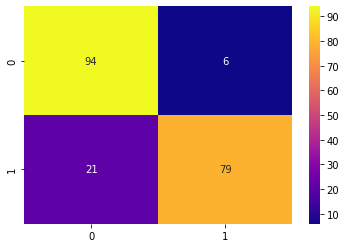

In [ ]:
import seaborn as sns

sns.heatmap(cm,cmap='plasma',annot=True)

# Corpus `20newsgroups`

In [ ]:
!pip install nltk

In [ ]:
from nltk import download

download('stopwords')
download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from sklearn.datasets import fetch_20newsgroups

(Docs,Y) = fetch_20newsgroups(
                        categories=['rec.autos','alt.atheism'],
                        remove=('headers', 'footers', 'quotes'),
                        return_X_y=True
                        )

In [ ]:
Docs[:3]

["\n\nI lived in Tokyo for a year and a half, and one of the many reasons why\nI intend to go back indefinitely is the freedom one enjoys when one can\nwalk anywhere (and I mean *anywhere*) at any time of day or night and not\nfeel uneasy, even if one's from an ethnic minority as I was.\n\nClues for Bobby (why do I bother?): (i) Tokyo is a city, and inner Tokyo\nis an inner city; (ii) there is a negligible level of violent crime, and\na street murder will be a lead item on *national* TV news; (iii) the\npopulation is almost universally atheistic.\n\nNext time I go for a stroll around Beirut at night, I'll let you know how\nit compares.\n\n\nCheers\n\nSimon",
 '\n\nReading newspapers to learn about this kind of stuff is not the best idea in\nthe world.  Newspaper reporters are notoriously ignorant on the subject of\nreligion, and are prone to exaggeration in the interests of having a "real"\nstory (that is, a bigger headline).\n\nLet\'s back up to 1935.  At this point, we have the Masor

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

def preprocesar_textos(docs,ignore_list:list=[]):
    strings_list = [re.sub(r'[^\w\s]', '', x.lower()) for x in docs]
    strings_list = [re.sub('[0-9]', '', x.lower()) for x in strings_list]
    SW = stopwords.words('english')
    for x in ignore_list:
        SW.remove(x)
    tokens_no_sw = [" ".join([word for word in word_tokenize(text) if not word in SW]) for
                         text in strings_list ]
    return tokens_no_sw

In [ ]:
documentos = preprocesar_textos(Docs)
documentos[:3]

['lived tokyo year half one many reasons intend go back indefinitely freedom one enjoys one walk anywhere mean anywhere time day night feel uneasy even ones ethnic minority clues bobby bother tokyo city inner tokyo inner city ii negligible level violent crime street murder lead item national tv news iii population almost universally atheistic next time go stroll around beirut night ill let know compares cheers simon',
 'reading newspapers learn kind stuff best idea world newspaper reporters notoriously ignorant subject religion prone exaggeration interests real story bigger headline lets back point masoretic text various targums translationscommentaries aramaic etc septuagint ancient greek translation masoretic text standard jewish text essentially vary places obvious corruptions copied faithfully copy copy passages past interpreted reference targums septuagint septuagint differs masoretic text two particulars first includes additional texts second passages variant readings masoretic t

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(max_features=8000)
X = vec.fit_transform(documentos)

X = np.array(X.todense())

print(X.shape)

(1074, 8000)


In [ ]:
vec.vocabulary_

[('zakat', 7991),
 ('yuppies', 7990),
 ('yuppie', 7989),
 ('yr', 7988),
 ('youve', 7987),
 ('youth', 7986)]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y,train_size=0.8,random_state=9)

## Usando nuestro clasificador

Hay que modificar la función de entrenamiento

In [ ]:
def fit(X_train,y_train):
    """
    Entrenamiento del clasificador NAIVE BAYES:
    Entrada: 
     - X_train: un DataFrame o Arreglo con instancias de entrenamiento.
    Salida:
     - una lista: [theta_n,theta_p] conteniendo 
       los vectores (np.arrays) de probabilidad de cada feature (palabra) 
       en correos Ham y Spam respectivamente. 
    """
    correos,k = X_train.shape # numero de palabras
    print(f"numero de palabras: {k}")
    print(f"número de correos: {correos}")
    #--- Revisamos si X_train es un dataframe o un arreglo de numpy ---    
    if not isinstance(X_train,pd.core.frame.DataFrame):  
        X_ = pd.DataFrame(X_train).T
    else:
        X_ = X_train.T.copy()
    
    #--- Entranamiento ---
    """ TU CODIGO AQUI"""    

    """ ------------- """
    print('theta shapes=',theta[0].shape,theta[1].shape)   # debe ser (k,) para ambos

    return theta[0],theta[1]

In [ ]:
theta_n, theta_p = fit(X_train,y_train)

numero de palabras: 8000
número de correos: 859
theta shapes= (8000,) (8000,)


In [ ]:
print(f"La suma para vector debe ser 1 \n Theta_p : {np.sum(theta_p)}")
print(f"La suma para vector debe ser 1 \n Theta_n : {np.sum(theta_n)}")

La suma para vector debe ser 1 
 Theta_p : 1.0
La suma para vector debe ser 1 
 Theta_n : 1.0


In [ ]:
y_predic = clasifica_LR(X_test,theta_p, theta_n)
print(y_predic)

[1 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1
 1 1 1 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 1
 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 1 0
 0 1 1 1 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1
 1 0 1 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0
 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0]


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_predic)
cm

array([[96,  6],
       [15, 98]])

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

print(f"Accuracy: {accuracy_score(y_test,y_predic)}")
print(f"Recall: {recall_score(y_test,y_predic)}")
print(f"Precision: {precision_score(y_test,y_predic)}")

Accuracy: 0.9023255813953488
Recall: 0.8672566371681416
Precision: 0.9423076923076923


## Usando sklearn

Usamos la implementación del clasificador Naive-Bayes de scikit-learn: 

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [ ]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np

clf_nb = MultinomialNB()
clf_nb.fit(X_train, y_train)
y_pred = clf_nb.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_pred)
cm

array([[ 91,  11],
       [  3, 110]])

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

print(f"Accuracy: {accuracy_score(y_test,y_pred)}")
print(f"Recall: {recall_score(y_test,y_pred)}")
print(f"Precision: {precision_score(y_test,y_pred)}")

Accuracy: 0.9348837209302325
Recall: 0.9734513274336283
Precision: 0.9090909090909091
